# Autoencoding & Self-Supervision

## Loading Libraries

In [10]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# Dataset's Iteration Performance
from tqdm import tqdm

# Time
import time

# OS
import re
import sys
import string
import unicodedata
from io import BytesIO
from zipfile import ZipFile
import requests, zipfile, io
from urllib.request import urlopen


# SciPy
from scipy.signal import convolve

# PyTorch
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import *
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


# IDLMAM Libraries
from idlmam import moveTo, run_epoch, set_seed, View
from idlmam import train_simple_network, set_seed, Flatten, weight_reset, train_network
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer


# Scikit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#  IPython Display
from IPython.display import Latex
from IPython.display import display_pdf
from IPython.display import set_matplotlib_formats

### Visualization Set-Up

In [11]:
%matplotlib inline

matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

### Setting Seeds

In [12]:
torch.backends.cudnn.deterministic=True

set_seed(42)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## How AutoEncoding Works

### Implementing PCA

In [14]:
# Input Size
D = 28*28 

#Hidden Layer Size
n = 2 
# Channels
C = 1

# Classes
classes = 10

In [15]:
class TransposeLinear(nn.Module): #Our class extends nn.Module, all PyTorch layers must extend this. 
    def __init__(self, linearLayer, bias=True):
        super().__init__()
        
        self.weight = linearLayer.weight
        if bias:
            self.bias = nn.Parameter(torch.Tensor(linearLayer.weight.shape[1]))
        else:
            self.register_parameter('bias', None)
    
    def forward(self, x):
        return F.linear(x, self.weight.t(), self.bias)

In [20]:
# Encoder
linearLayer = nn.Linear(D,  n, bias=False)
pca_encoder = nn.Sequential(
    nn.Flatten(),
    linearLayer,
)

# Decoder
pca_decoder = nn.Sequential(
    TransposeLinear(linearLayer, bias=False),
    View(-1, 1, 28, 28)
)

# PCA Model
pca_model = nn.Sequential(
    pca_encoder,
    pca_decoder
)

PCA Initialization & Loss Function

In [21]:
# Orthogonal Random Set
nn.init.orthogonal_(linearLayer.weight)

Parameter containing:
tensor([[ 0.0611, -0.0175,  0.0497,  ..., -0.0421,  0.0089,  0.0435],
        [-0.0204,  0.0747,  0.0018,  ..., -0.0180, -0.0335,  0.0028]],
       requires_grad=True)

In [22]:
# Loss Function
mse_loss = nn.MSELoss() 

# PCA Loss Function
def mseWithOrthoLoss(x, y):
    W = linearLayer.weight
    I = torch.eye(W.shape[0]).to(device)
    normal_loss =  mse_loss(x, y) 
    regularization_loss = 0.1*mse_loss(torch.mm(W, W.t()), I)
    return normal_loss + regularization_loss

### Implementing PCA with PyTorch

In [23]:
class AutoEncodeDataset(Dataset):

    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset.__getitem__(idx)
        return x, x

## Loading Data

In [24]:
# Train Set
train_data = AutoEncodeDataset(torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True))

# Test Set
test_data_xy = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
test_data_xx = AutoEncodeDataset(test_data_xy)

# Data Loader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data_xx, batch_size=128)

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 9912422/9912422 [00:00<00:00, 143358589.45it/s]
Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 28881/28881 [00:00<00:00, 30028679.68it/s]
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 1648877/1648877 [00:00<00:00, 114598276.63it/s]
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden

100%|██████████| 4542/4542 [00:00<00:00, 4288727.77it/s]
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Training PCA Model as follows:

In [25]:
train_network(pca_model, 
mseWithOrthoLoss, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
device=device)

Training:  99%|█████████▉| 465/469 [00:10<00:00, 48.32it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:09<00:00, 51.04it/s]
                                                           
Training:  99%|█████████▉| 464/469 [00:09<00:00, 50.24it/s]
                                                           
Training:  99%|█████████▉| 465/469 [00:09<00:00, 50.57it/s]
                                                           
Training:  99%|█████████▉| 466/469 [00:09<00:00, 50.74it/s]
                                                           
Training:  99%|█████████▉| 466/469 [00:09<00:00, 46.38it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:09<00:00, 50.67it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:09<00:00, 48.75it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:0

,epoch,total time,train loss,test loss
0,0,10.104845,0.064002,0.057803
1,1,19.552940,0.057893,0.057827
2,2,29.010308,0.057883,0.057814
3,3,38.429319,0.057886,0.057815
4,4,47.862324,0.057887,0.057799
5,5,57.383455,0.057889,0.057850
6,6,66.785117,0.057890,0.057835
7,7,76.227460,0.057888,0.057813
8,8,85.686292,0.057889,0.057843
9,9,95.040685,0.057895,0.057830


### Visualizing PCA Results

In [26]:
def encode_batch(encoder, dataset_to_encode):
    projected = []
    labels = []
    encoder = encoder.eval()
    encoder = encoder.cpu()
    with torch.no_grad():
        for x, y in  DataLoader(dataset_to_encode, batch_size=128):
            z = encoder(x.cpu()) 
            projected.append( z.numpy() ) 
            labels.append( y.cpu().numpy().ravel() )
    projected = np.vstack(projected)
    labels = np.hstack(labels)
    return projected, labels


projected, labels = encode_batch(pca_encoder, test_data_xy)

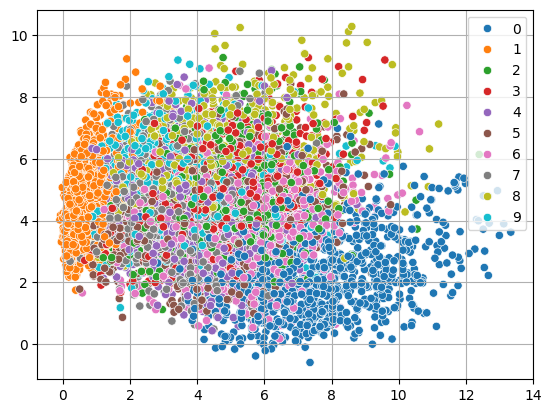

In [27]:
sns.scatterplot(x=projected[:,0], 
y=projected[:,1], 
hue=[str(l) for l in labels], 
hue_order=[str(i) for i in range(10)], 
legend="full")

plt.grid(True)
plt.show()

In [28]:
def showEncodeDecode(encode_decode, x):
    encode_decode = encode_decode.eval()
    encode_decode = encode_decode.cpu()
    with torch.no_grad():
        x_recon = encode_decode(x.cpu())
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(x.numpy()[0,:])
    axarr[1].imshow(x_recon.numpy()[0,0,:])

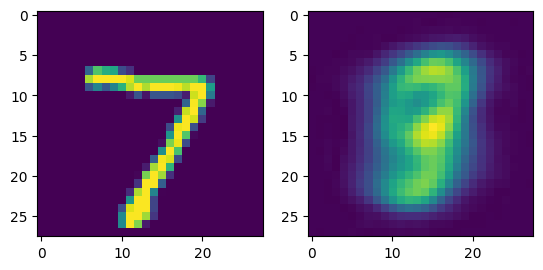

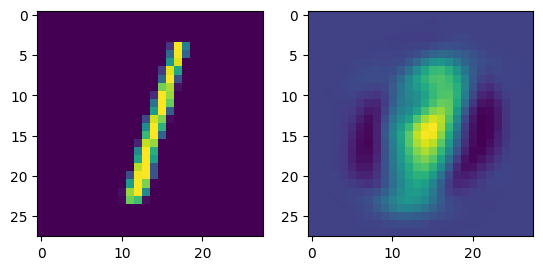

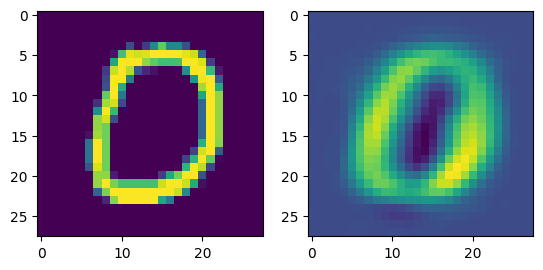

In [29]:
showEncodeDecode(pca_model, test_data_xy[0][0])

showEncodeDecode(pca_model, test_data_xy[2][0])

showEncodeDecode(pca_model, test_data_xy[10][0])

### A Simple Non-Linear PCA

In [30]:
pca_nonlinear_encode = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(), 
)

pca_nonlinear_decode = nn.Sequential(
    nn.Linear(n, D),
    View(-1, 1, 28, 28)
)

pca_nonlinear = nn.Sequential(
    pca_nonlinear_encode,
    pca_nonlinear_decode
)

Training PCA Non-Linear Model as follows:

In [31]:
train_network(pca_nonlinear, 
mse_loss, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
device=device)

Training: 100%|█████████▉| 467/469 [00:09<00:00, 47.94it/s]
                                                           
Training:  99%|█████████▉| 465/469 [00:09<00:00, 48.77it/s]
                                                           
Training:  99%|█████████▉| 464/469 [00:09<00:00, 47.86it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:09<00:00, 48.40it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:09<00:00, 47.62it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:09<00:00, 47.20it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:09<00:00, 48.99it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:09<00:00, 49.16it/s]
                                                           
Training:  99%|█████████▉| 465/469 [00:0

,epoch,total time,train loss,test loss
0,0,9.607913,0.133296,0.069562
1,1,19.278630,0.066857,0.066195
2,2,28.864158,0.065749,0.065633
3,3,38.502700,0.065101,0.064802
4,4,48.110994,0.064110,0.063549
5,5,57.715920,0.062622,0.061727
6,6,67.310467,0.060794,0.059827
7,7,76.909224,0.059180,0.058362
8,8,86.542929,0.058051,0.057418
9,9,96.122715,0.057350,0.056863


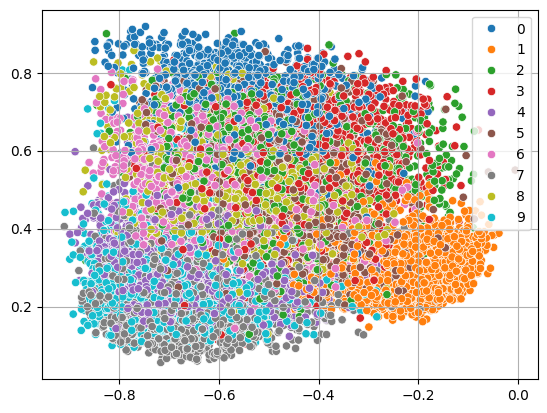

In [32]:
projected, labels = encode_batch(pca_nonlinear_encode, test_data_xy)

sns.scatterplot(x=projected[:,0], 
y=projected[:,1], 
hue=[str(l) for l in labels], 
hue_order=[str(i) for i in range(10)], 
legend="full" )

plt.grid(True)
plt.show()

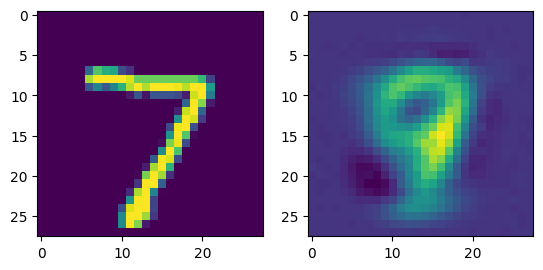

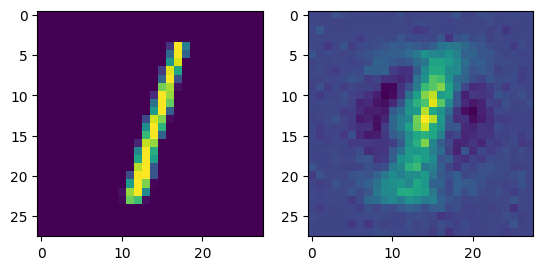

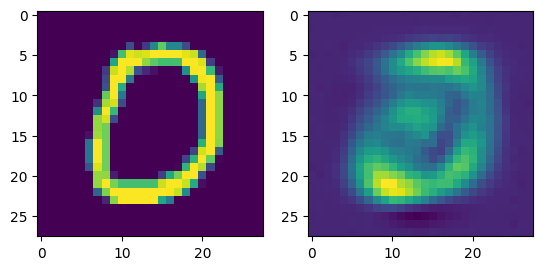

In [33]:
showEncodeDecode(pca_nonlinear, test_data_xy[0][0])

showEncodeDecode(pca_nonlinear, test_data_xy[2][0])

showEncodeDecode(pca_nonlinear, test_data_xy[10][0])

## Designing AutoEncoding Neural Networks

### Implementing an AutoEncoder

GetLayer Helper Function as follows:

In [35]:
def getLayer(in_size, out_size):
    return nn.Sequential( 
        nn.Linear(in_size,  out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU())

In [36]:
# AutoEncoder
auto_encoder = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D//2), 
    getLayer(D//2, D//3),
    getLayer(D//3, D//4),
    nn.Linear(D//4,  n), 
)

#AutoDecoder 
auto_decoder = nn.Sequential(
    getLayer(n, D//4), 
    getLayer(D//4, D//3),
    getLayer(D//3, D//2),
    nn.Linear(D//2,  D),
    View(-1, 1, 28, 28) 
)

# Encoder-Decoder
auto_encode_decode = nn.Sequential(
    auto_encoder,
    auto_decoder
)

Visualizing AutoEncoder Results as follows:

In [37]:
train_network(auto_encode_decode, 
mse_loss, train_loader, 
test_loader=test_loader, 
epochs=10, 
device=device)

Training:  99%|█████████▉| 466/469 [00:12<00:00, 35.17it/s]
                                                           
Training:  99%|█████████▉| 466/469 [00:12<00:00, 38.14it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:12<00:00, 36.43it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:12<00:00, 38.13it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:12<00:00, 37.50it/s]
                                                           
Training: 100%|█████████▉| 467/469 [00:12<00:00, 38.05it/s]
                                                           
Training: 100%|██████████| 469/469 [00:12<00:00, 34.88it/s]
                                                           
Training: 100%|██████████| 469/469 [00:12<00:00, 39.30it/s]
                                                           
Epoch: 100%|██████████| 10/10 [02:20<00:

,epoch,total time,train loss,test loss
0,0,12.531259,0.050223,0.043999
1,1,25.109608,0.043867,0.041862
2,2,37.743033,0.042120,0.040146
3,3,50.316211,0.041049,0.039532
4,4,62.799964,0.040342,0.039168
5,5,75.286244,0.039878,0.038033
6,6,87.747697,0.039427,0.038033
7,7,100.165884,0.038918,0.037592
8,8,112.654177,0.038789,0.037131
9,9,125.051208,0.038380,0.037028


<AxesSubplot: >

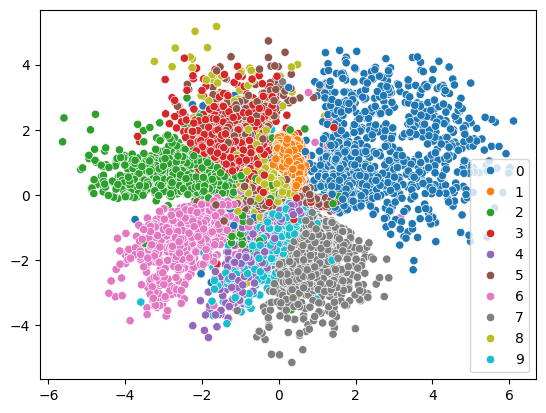

In [38]:
projected, labels = encode_batch(auto_encoder, test_data_xy)

sns.scatterplot(x=projected[:,0], 
y=projected[:,1], 
hue=[str(l) for l in labels], 
hue_order=[str(i) for i in range(10)], 
legend="full")

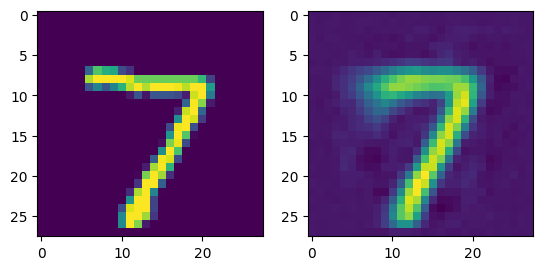

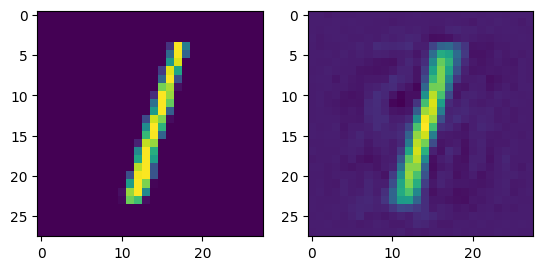

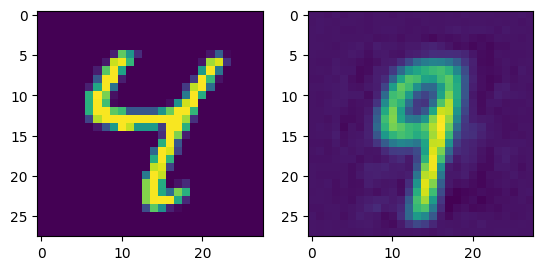

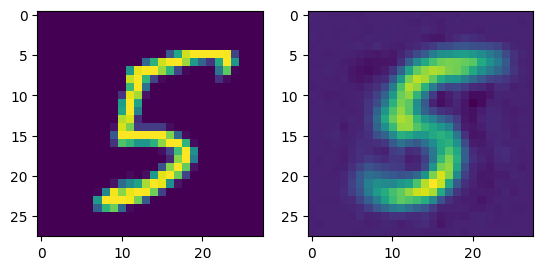

In [39]:
showEncodeDecode(auto_encode_decode, test_data_xy[0][0])

showEncodeDecode(auto_encode_decode, test_data_xy[2][0])

showEncodeDecode(auto_encode_decode, test_data_xy[6][0])

showEncodeDecode(auto_encode_decode, test_data_xy[23][0])

## Bigger AutoEncoder

In [40]:
# Larger AutoEncoder
auto_encoder_big = nn.Sequential(
    nn.Flatten(),
    getLayer(D, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D*2),
)

#Larger AutoDecoder 
auto_decoder_big = nn.Sequential(
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

# Larger Encoder-Decoder
auto_encode_decode_big = nn.Sequential(
    auto_encoder_big,
    auto_decoder_big
)

Training Larger AutoEncoderDecoder Model as follows:

In [41]:
train_network(auto_encode_decode_big, 
mse_loss, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
device=device)

Training: 100%|█████████▉| 468/469 [00:19<00:00, 24.10it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:19<00:00, 23.36it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:19<00:00, 23.83it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:19<00:00, 23.82it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:19<00:00, 24.21it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:19<00:00, 23.82it/s]
                                                           
Epoch: 100%|██████████| 10/10 [03:35<00:00, 21.53s/it]


,epoch,total time,train loss,test loss
0,0,19.776372,0.023451,0.013355
1,1,39.599234,0.012734,0.010018
2,2,59.339484,0.010641,0.009322
3,3,79.061918,0.009183,0.009120
4,4,98.828292,0.008643,0.007420
5,5,118.559878,0.007706,0.006902
6,6,138.234086,0.007384,0.006521
7,7,158.004350,0.006934,0.006353
8,8,177.719184,0.006658,0.006117
9,9,197.480558,0.007728,0.007607


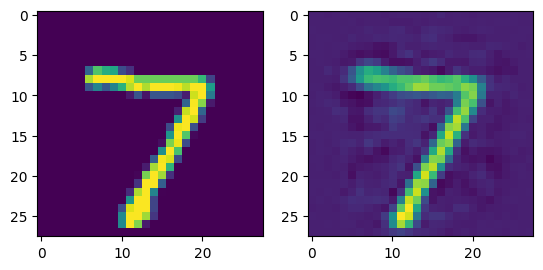

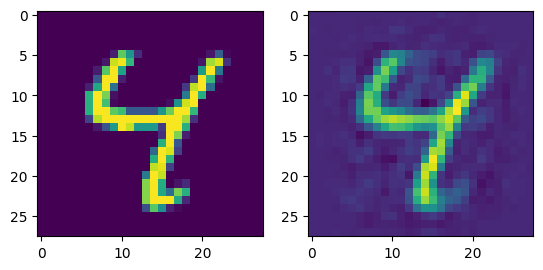

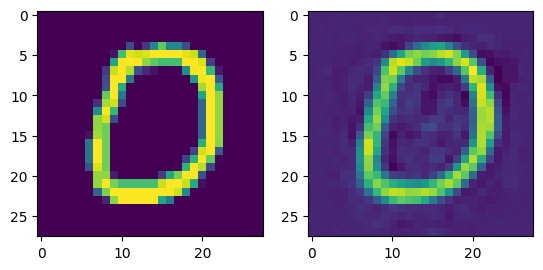

In [42]:
showEncodeDecode(auto_encode_decode_big, test_data_xy[0][0])

showEncodeDecode(auto_encode_decode_big, test_data_xy[6][0])

showEncodeDecode(auto_encode_decode_big, test_data_xy[10][0])

### Robustness to Noise

Adding Noisyness 

In [43]:
normal = torch.distributions.Normal(0, 0.5)

In [44]:
def addNoise(x, device='cpu'): 
    return x + normal.sample(sample_shape=torch.Size(x.shape)).to(device)

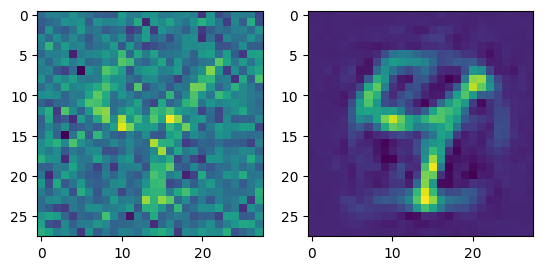

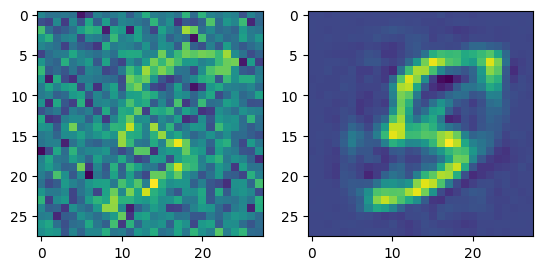

In [45]:
showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[6][0]))

showEncodeDecode(auto_encode_decode_big, addNoise(test_data_xy[23][0]))

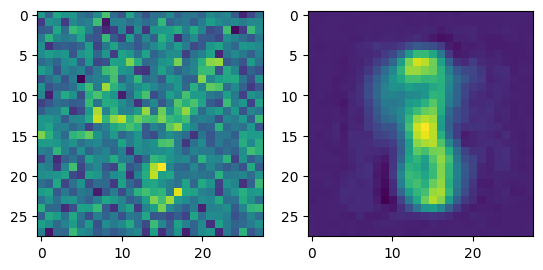

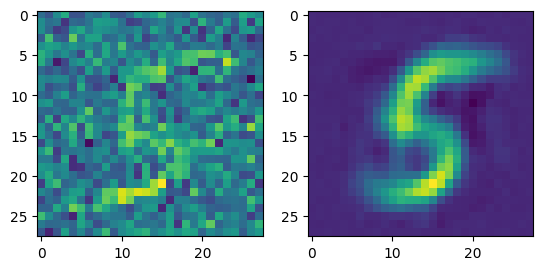

In [46]:
showEncodeDecode(auto_encode_decode, addNoise(test_data_xy[6][0]))

showEncodeDecode(auto_encode_decode, addNoise(test_data_xy[23][0]))

## Denoising AutoEncoders

### Denoising with Gaussian Noise

In [47]:
class AdditiveGausNoise(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        if self.training:
             return addNoise(x, device=device)
        else: 
            return x

In [48]:
# Noisy Encoder
dnauto_encoder_big = nn.Sequential(
    nn.Flatten(),
    AdditiveGausNoise(), 
    getLayer(D, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D*2),
)

# Noisy Decoder
dnauto_decoder_big = nn.Sequential(
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    getLayer(D*2, D*2),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

# Noisy Encoder-Decoder
dnauto_encode_decode_big = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)

Training Noisy Model as follows:

In [49]:
train_network(dnauto_encode_decode_big, 
mse_loss, 
train_loader, 
test_loader=test_loader, 
epochs=10, 
device=device)

Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.23it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.99it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.44it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:21<00:00, 22.65it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.66it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 23.17it/s]
                                                           
Epoch: 100%|██████████| 10/10 [03:44<00:00, 22.41s/it]


,epoch,total time,train loss,test loss
0,0,20.508960,0.032001,0.018329
1,1,41.034338,0.020884,0.015011
2,2,61.474936,0.018875,0.013238
3,3,81.960865,0.017652,0.012103
4,4,102.447451,0.016465,0.011423
5,5,122.947826,0.015764,0.010964
6,6,143.486061,0.015313,0.010867
7,7,165.254781,0.014856,0.010856
8,8,185.735011,0.014622,0.009964
9,9,206.231930,0.014228,0.009863


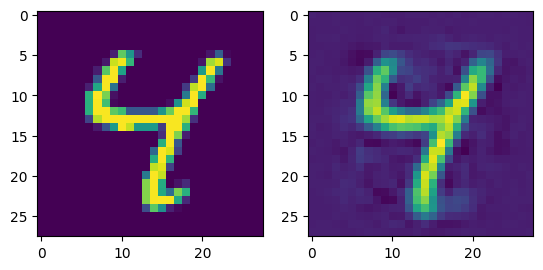

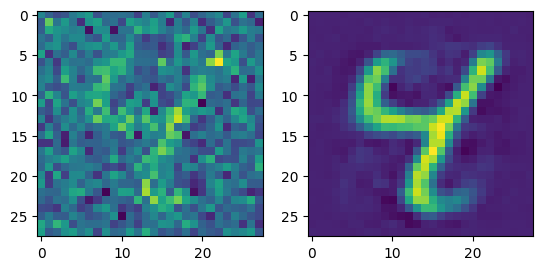

In [50]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[6][0])

showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[6][0]))

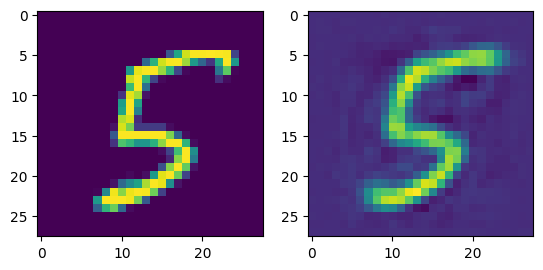

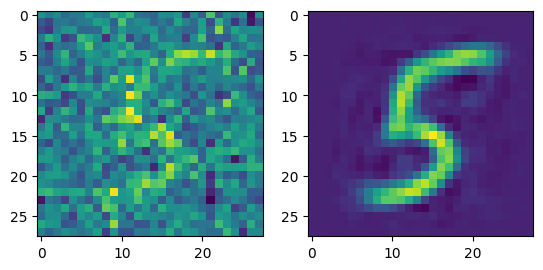

In [51]:
showEncodeDecode(dnauto_encode_decode_big, test_data_xy[23][0])

showEncodeDecode(dnauto_encode_decode_big, addNoise(test_data_xy[23][0]))

Denoising with DropOut

In [53]:
# Dropping Out Encoder
dnauto_encoder_dropout = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(p=0.2), 
    getLayer(D, D*2),
    nn.Dropout(), 
    getLayer(D*2, D*2),
    nn.Dropout(),
    getLayer(D*2, D*2),
    nn.Dropout(),
    nn.Linear(D*2,  D*2)
)

# Dropping Out Decoder
dnauto_decoder_dropout = nn.Sequential(
    getLayer(D*2, D*2),
    nn.Dropout(),
    getLayer(D*2, D*2),
    nn.Dropout(),
    getLayer(D*2, D*2),
    nn.Dropout(),
    nn.Linear(D*2,  D),
    View(-1, 1, 28, 28)
)

# Dropping Out Encoder-Decoder
dnauto_encode_decode_dropout = nn.Sequential(
    dnauto_encoder_big,
    dnauto_decoder_big
)

Training on Dropping Encoder-Decoder Model is as follows:

In [54]:
 train_network(dnauto_encode_decode_dropout, 
 mse_loss, 
 train_loader, 
 test_loader=test_loader, 
 epochs=10, 
 device=device)

Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.80it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.71it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.64it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.90it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 22.94it/s]
                                                           
Training: 100%|█████████▉| 468/469 [00:20<00:00, 21.58it/s]
                                                           
Epoch: 100%|██████████| 10/10 [03:43<00:00, 22.32s/it]


,epoch,total time,train loss,test loss
0,0,20.460121,0.014728,0.009977
1,1,40.982426,0.014591,0.013583
2,2,61.422033,0.014264,0.009085
3,3,81.969469,0.013255,0.009001
4,4,102.461420,0.013038,0.009097
5,5,123.146797,0.012884,0.008473
6,6,143.617922,0.012542,0.008302
7,7,164.107562,0.012335,0.008275
8,8,184.560699,0.012173,0.008139
9,9,205.392542,0.012122,0.007975


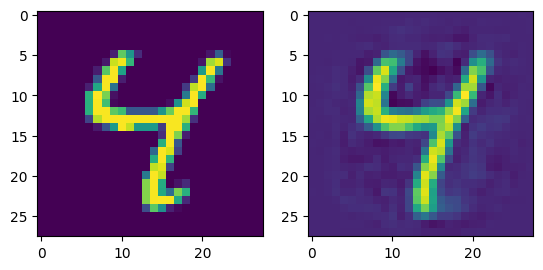

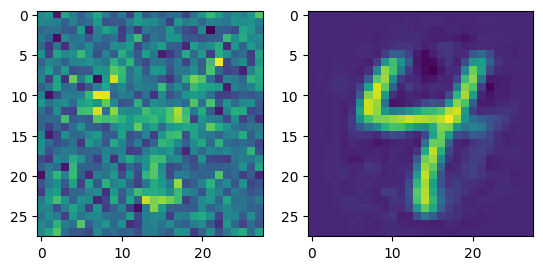

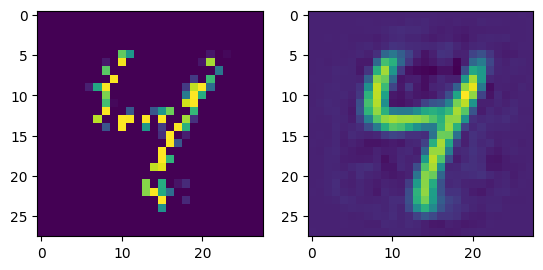

In [55]:
# On Clean Data
showEncodeDecode(dnauto_encode_decode_dropout, test_data_xy[6][0]) 

# Gaussian Noise
showEncodeDecode(dnauto_encode_decode_dropout, addNoise(test_data_xy[6][0])) 

# DropOut Noise
showEncodeDecode(dnauto_encode_decode_dropout, nn.Dropout()(test_data_xy[6][0]))

## AutoRegressive Models for Time Series & Sequences

### Implementing The Char-RNN AutoRegressive Text Model

In [56]:
all_data = []

resp = urlopen("https://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt")

shakespear_100k = resp.read()

shakespear_100k = shakespear_100k.decode('utf-8').lower()

In [57]:
vocab2indx = {} 
for char in shakespear_100k: 
    if char not in vocab2indx: 
        vocab2indx[char] = len(vocab2indx) 

indx2vocab = {}

for k, v in vocab2indx.items():
    indx2vocab[v] = k
print("Vocab Size: ", len(vocab2indx))
print("Total Characters:", len(shakespear_100k))

Vocab Size:  36
Total Characters: 99993


Defining an AutoRegressive Constructor:

In [58]:
class AutoRegressiveDataset(Dataset):

    def __init__(self, large_string, MAX_CHUNK=500):
        self.doc = large_string
        self.MAX_CHUNK = MAX_CHUNK

    def __len__(self):
        return (len(self.doc)-1) // self.MAX_CHUNK

    def __getitem__(self, idx):
        start = idx*self.MAX_CHUNK
        sub_string = self.doc[start:start+self.MAX_CHUNK]
        x = [vocab2indx[c] for c in sub_string]
        
        sub_string = self.doc[start+1:start+self.MAX_CHUNK+1]
        y = [vocab2indx[c] for c in sub_string]
        return torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)

In [59]:
class AutoRegressive(nn.Module):

    def __init__(self, num_embeddings, embd_size, hidden_size, layers=1):
        super(AutoRegressive, self).__init__()
        self.hidden_size = hidden_size
        self.embd = nn.Embedding(num_embeddings, embd_size)
        self.layers = nn.ModuleList([nn.GRUCell(embd_size, hidden_size)] + 
                                     [nn.GRUCell(hidden_size, hidden_size) for i in range(layers-1)])
        self.norms = nn.ModuleList([nn.LayerNorm(hidden_size) for i in range(layers)])
        
        self.pred_class = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(hidden_size), 
            nn.Linear(hidden_size, num_embeddings) 
        )
        
    def initHiddenStates(self, B):
        return [torch.zeros(B, self.hidden_size, device=device) for _ in range(len(self.layers))]
        
    def step(self, x_in, h_prevs=None):
        if len(x_in.shape) == 1: 
            x_in = self.embd(x_in) 

        if h_prevs is None:
            h_prevs = self.initHiddenStates(x_in.shape[0])
        
        for l in range(len(self.layers)):
            h_prev = h_prevs[l]
            h = self.norms[l](self.layers[l](x_in, h_prev))

            h_prevs[l] = h
            x_in = h
        return self.pred_class(x_in)
    
    def forward(self, input):
        B = input.size(0)
        T = input.size(1)
        
        x = self.embd(input) 
        
        h_prevs = self.initHiddenStates(B)
        
        last_activations = []
        for t in range(T):
            x_in = x[:,t,:] #(B, D)
            last_activations.append(self.step(x_in, h_prevs))
        
        last_activations = torch.stack(last_activations, dim=1) 
        
        return last_activations

## Loading AutoRegressive Data

In [60]:
# Dataset
autoRegData = AutoRegressiveDataset(shakespear_100k, MAX_CHUNK=250)

# Loader
autoReg_loader = DataLoader(autoRegData, batch_size=128, shuffle=True)

# Model
autoReg_model = AutoRegressive(len(vocab2indx), 32, 128, layers=2)
autoReg_model = autoReg_model.to(device)

for p in autoReg_model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -2, 2))

Implementing an AutoRegressive Loss Function:

In [61]:
# AutoRegressive Loss Function
def CrossEntLossTime(x, y):
    cel = nn.CrossEntropyLoss()
    
    T = x.size(1)
    
    loss = 0
    
    for t in range(T):
        loss += cel(x[:,t,:], y[:,t]) 
    
    return loss

Model Training is as follows:

In [62]:
train_network(autoReg_model, 
CrossEntLossTime, 
autoReg_loader, 
epochs=100, 
device=device)

Epoch: 100%|██████████| 100/100 [03:24<00:00,  2.04s/it]


,epoch,total time,train loss
0,0,2.105933,873.648926
1,1,4.142886,798.292664
2,2,6.183865,773.037354
3,3,8.209039,764.859756
4,4,10.288753,761.592133
...,...,...,...
95,95,195.382377,399.372162
96,96,197.380869,396.042877
97,97,199.413070,396.435272
98,98,201.426131,396.424187


### Autoregressive Models are Generative Models

In [63]:
# Setting sample's procedure
autoReg_model = autoReg_model.eval()

# Sampling
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)

In [64]:
# Seeding
seed = "EMILIA:".lower()

cur_len = len(seed)

sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

In [65]:
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i]) 
        h = h[:,-1,:] 
        h = F.softmax(h, dim=1) 
        next_tokens = torch.multinomial(h, 1) 
        sampling[:,i] = next_tokens 
        cur_len += 1

100%|██████████| 493/493 [00:54<00:00,  9.00it/s]


In [66]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
to hell: if must mear, so man fruch desire see
to the wistreing.
but strength, good art goin'd; shallst of my to-chas shall sife was to good thy syacto
and for you were mery decouthand in arms serving
men more all agair takly too the moldom the breaked,
the's makron, by your bele they mine
thy terbll
dis
pad as oother heard: not us;
but i promeds, ay it will the sie have my my blood yor
but then stu-wed my to controus, brutug your hand flies:
that hear soll as entry, it's not in our the 


### Changing Samples with Temperature

In [67]:
cur_len = len(seed)

# Temperature Sample's Behaviour
temperature = 0.75 

for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] 
        h = F.softmax(h/temperature, dim=1) 
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

100%|██████████| 493/493 [00:54<00:00,  8.97it/s]


In [68]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
therefore then i am to she pray of sweet my boy arms thy andot
well, sir, i think for conterfor jyself to brother.

tecothous:
the britillow,, my to the man your day them
to the was i was here as flirt,
if they shall guiltion of thy start:
i am a vark from the terray, part of your bright, i am protes.

duke of mare marvar:
lo i have comming cuted there they should brother;
why her was here have are you good good proves of the wrong naw ford
ding
that it the command and with there werd in


In [69]:
cur_len = len(seed)

# Temperature Sample's Behaviour
temperature = 0.05 
for i in tqdm(range(cur_len, sampling.size(1))):
    with torch.no_grad():
        h = autoReg_model(sampling[:,0:i])
        h = h[:,-1,:] #Grab the last time step
        h = F.softmax(h/temperature, dim=1) #make probabilities
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens

        cur_len += 1

100%|██████████| 493/493 [00:54<00:00,  9.01it/s]


In [70]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]

print("".join(s))

emilia:
there the with the proved the stand to the stain to the stains
and the stand the stand to the stand to the stains
and the stand the shall the stand to the proveral
that i will the proved the shall the stains
and the stand the stand to the shall the stand to the stand
the proved the stand to the stand to the storr;
and there the stay'd the proved the shall the shall the stand
the stand the proved the with the stand to the stand to the storr:
then the stay'd the stand the proved the stand 


### Faster Sampling

In [71]:
# Setting Seed
seed = "EMILIA:".lower()

# Getting Seed
cur_len = len(seed)

# Smapling
sampling = torch.zeros((1, 500), dtype=torch.int64, device=device)
sampling[0,0:cur_len] = torch.tensor([vocab2indx[x] for x in seed])

# Choosing Temperature
temperature = 0.75

with torch.no_grad():
    h_prevs = autoReg_model.initHiddenStates(1)
    for i in range(0, cur_len):
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

    for i in tqdm(range(cur_len, sampling.size(1))):
        h = F.softmax(h/temperature, dim=1) 
        next_tokens = torch.multinomial(h, 1)
        sampling[:,i] = next_tokens
        cur_len += 1
        h = autoReg_model.step(sampling[:,i], h_prevs=h_prevs)

100%|██████████| 493/493 [00:00<00:00, 1253.58it/s]


In [72]:
s = [indx2vocab[x] for x in sampling.cpu().numpy().flatten()]
print("".join(s))

emilia:
a-tell in a princean me;
bexigl me poor you when you peace, thy staphtion's
and store this we hath thrame thou does are your that fear
of a jolad hand i king; her faich, and my so wish hear will cause thee
to doth the closp art their their wife.

timallo:
where of them f thy from strut them himself it the trull for ither baton's fisont his child.

aigho:
i pern a follors, as so.

rostuck:
i would not was you face to thee, and at singles and between take
the would the thou ameny good not 


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=342f6690-40a5-4be7-8b03-a1ad9dda03ef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>